# Forecast for price per kWh in San Jose

In [9]:
#imports
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import holidays
import seaborn as sns

In [10]:
df = pd.read_csv("D202.csv")

In [11]:
df.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN


In [12]:
print(len(df))

70368


In [13]:
df["UNITS"].unique()
len(df["COST"].unique())
df["NOTES"].unique()

array([nan])

In [14]:
df.drop(["TYPE", "UNITS", "NOTES" ], axis=1, inplace=True)

In [15]:
df["START TIME"].dtype

dtype('O')

In [16]:
def normalize_time_str(t):
    parts = t.split(':')
    if len(parts) == 2:
        return f"{int(parts[0]):02d}:{int(parts[1]):02d}:00"
    elif len(parts) == 3:
        return f"{int(parts[0]):02d}:{int(parts[1]):02d}:{int(parts[2]):02d}"
    else:
        return "00:00:00"  # fallback oder np.nan

df['START TIME'] = df['START TIME'].astype(str).apply(normalize_time_str)
df['END TIME'] = df['END TIME'].astype(str).apply(normalize_time_str)

df['START TIME'] = pd.to_timedelta(df['START TIME'])
df['END TIME'] = pd.to_timedelta(df['END TIME'])

df['DAUER'] = df['END TIME'] - df['START TIME']


In [17]:
print(df["START TIME"][43])
print(df["END TIME"][4])
print(df["DAUER"][4])

0 days 10:45:00
0 days 01:14:00
0 days 00:14:00


In [18]:
df["DAUER"].unique()

<TimedeltaArray>
['0 days 00:14:00']
Length: 1, dtype: timedelta64[ns]

In [19]:
df.drop(["END TIME", "DAUER"], axis=1, inplace=True)

In [20]:
df['START TIME'] = pd.to_timedelta(df['START TIME'])

In [21]:
df["START_SECONDS"] = df["START TIME"].dt.total_seconds()
df['START_SECONDS'].dtype

dtype('float64')

In [22]:
print(df["START_SECONDS"].describe())
print(df["START_SECONDS"].head())


count    70368.000000
mean     42749.590723
std      24940.946408
min          0.000000
25%      21375.000000
50%      42750.000000
75%      64125.000000
max      85500.000000
Name: START_SECONDS, dtype: float64
0       0.0
1     900.0
2    1800.0
3    2700.0
4    3600.0
Name: START_SECONDS, dtype: float64


In [23]:
df['start_norm'] = df['START_SECONDS'] / 86400

df['start_sin'] = np.sin(2 * np.pi * df['start_norm'])
df['start_cos'] = np.cos(2 * np.pi * df['start_norm'])


In [24]:
len(df["start_cos"].unique())

87

In [25]:
df["DATE"] = pd.to_datetime(df["DATE"], format="%m/%d/%Y")

In [26]:
df["DATE"].dtype

dtype('<M8[ns]')

In [27]:
df["weekday"] = df['DATE'].dt.weekday

# Zykliche Kodierung (sin & cos)
df["weekday_sin"] = np.sin(2 * np.pi * df["weekday"] / 7)
df["weekday_cos"] = np.cos(2 * np.pi * df["weekday"] / 7)

In [28]:
# Monat extrahieren
df["month"] = df["DATE"].dt.month

# Zykliche Kodierung des Monats
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

In [29]:
df["is_leap_year"] = df["DATE"].dt.is_leap_year

In [30]:
df["day_of_year"] = df["DATE"].dt.dayofyear
days_in_year = np.where(df["is_leap_year"], 366, 365)

df["dayofyear_sin"] = np.sin(2 * np.pi * df["day_of_year"] / days_in_year)
df["dayofyear_cos"] = np.cos(2 * np.pi * df["day_of_year"] / days_in_year)

In [31]:
# Jahr normalisiert
df["year"] = df["DATE"].dt.year
df["year"] = (df["year"] - df["year"].min()) / (df["year"].max() - df["year"].min())


In [32]:
# US-Feiertage für Kalifornien
us_holidays = holidays.US(state="CA")

# Feiertagserkennung
df["is_holiday"] = df["DATE"].isin(us_holidays).astype(int)

In [33]:
df["is_weekend"] = (df["DATE"].dt.weekday >= 5).astype(int)

In [34]:
df.drop(["weekday", "month", "day_of_year", "is_leap_year", "START_SECONDS", "start_norm"], axis=1, inplace=True)


In [35]:
df["year"][44340]

np.float64(1.0)

In [36]:
df.head()

,DATE,START TIME,USAGE,COST,start_sin,start_cos,weekday_sin,weekday_cos,month_sin,month_cos,dayofyear_sin,dayofyear_cos,year,is_holiday,is_weekend
0,2016-10-22,0 days 00:00:00,0.01,$0.00,0.000000,1.000000,-0.974928,-0.222521,-0.866025,0.5,-0.932655,0.360771,0.0,0,1
1,2016-10-22,0 days 00:15:00,0.01,$0.00,0.065403,0.997859,-0.974928,-0.222521,-0.866025,0.5,-0.932655,0.360771,0.0,0,1
2,2016-10-22,0 days 00:30:00,0.01,$0.00,0.130526,0.991445,-0.974928,-0.222521,-0.866025,0.5,-0.932655,0.360771,0.0,0,1
3,2016-10-22,0 days 00:45:00,0.01,$0.00,0.195090,0.980785,-0.974928,-0.222521,-0.866025,0.5,-0.932655,0.360771,0.0,0,1
4,2016-10-22,0 days 01:00:00,0.01,$0.00,0.258819,0.965926,-0.974928,-0.222521,-0.866025,0.5,-0.932655,0.360771,0.0,0,1


In [37]:
df["COST"] = pd.to_numeric(df["COST"].replace('[\$,]', '', regex=True))


<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
C:\Users\Julia\AppData\Local\Temp\ipykernel_14376\2533260980.py:1: SyntaxWarning: invalid escape sequence '\$'
  df["COST"] = pd.to_numeric(df["COST"].replace('[\$,]', '', regex=True))


In [38]:
color_pal = sns.color_palette()

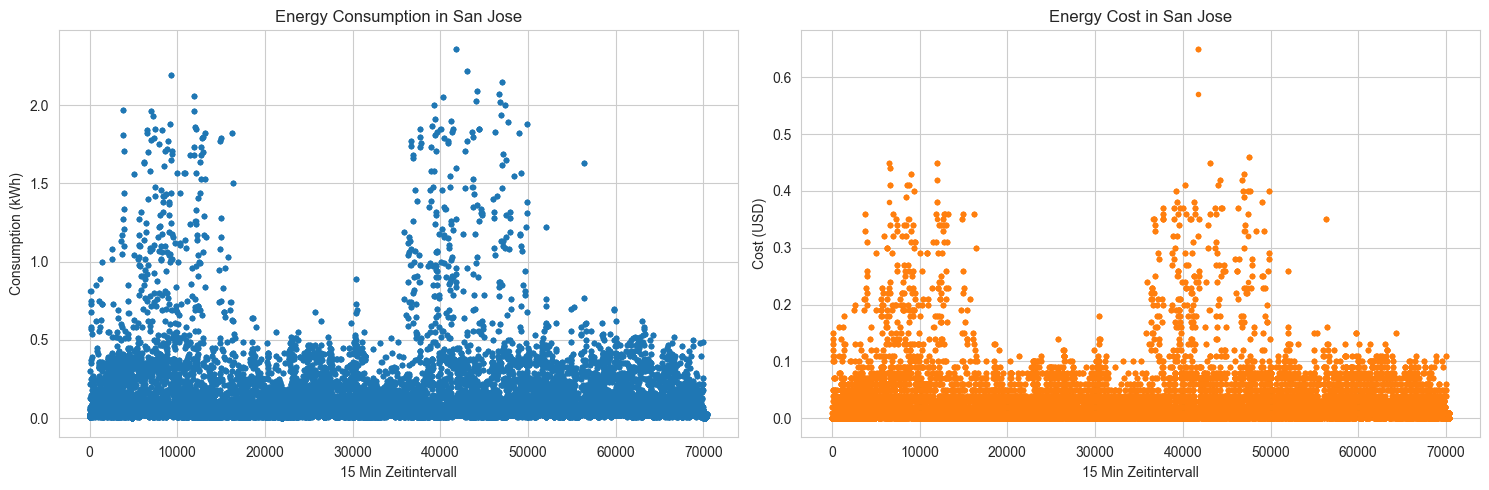

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

df["USAGE"].plot(
    style=".",
    ax=axes[0],
    color=color_pal[0],
    title="Energy Consumption in San Jose"
)
axes[0].set_ylabel("Consumption (kWh)")
axes[0].set_xlabel("15 Min Zeitintervall")

# Plot 2: COST
df["COST"].plot(
    style=".",
    ax=axes[1],
    color=color_pal[1],
    title="Energy Cost in San Jose"
)
axes[1].set_ylabel("Cost (USD)")
axes[1].set_xlabel("15 Min Zeitintervall")

plt.tight_layout()
plt.show()

In [40]:
features = [
    "start_sin", "start_cos",
    "weekday_sin", "weekday_cos",
    "month_sin", "month_cos",
    "dayofyear_sin", "dayofyear_cos",
    "year", "USAGE",  # bereits normalisiert
    "is_weekend", "is_holiday"
]

In [41]:
# Sortieren nach Zeit – sehr wichtig bei Zeitreihen!
df = df.sort_values("DATE").reset_index(drop=True)

# Eingabe- und Zielmatrix bauen
X = df[features]
y = df["COST"]

In [42]:
train_size = int(len(df) * (75 / 100))
print(len(df))


X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


70368


In [43]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Erstelle DMatrix für XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Setze die Hyperparameter
params = {
    'max_depth': 3,
    'learning_rate': 0.015,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': 42
}

# Trainiere das Modell mit Early Stopping
watchlist = [(dtest, 'eval'), (dtrain, 'train')]  # eval_list für Performance-Überwachung
model = xgb.train(
    params,
    dtrain,
    num_boost_round=100000,            # Maximale Runden
    early_stopping_rounds=50,        # Stoppe, wenn sich der Fehler nicht verbessert
    evals=watchlist,                 # Überwachungsset
    verbose_eval=True                # Ausgabe des Trainingsfortschritts
)

# Beste Iteration für Modell und Vorhersage
print(f"Beste Iteration: {model.best_iteration}")
y_pred = model.predict(dtest)

# Berechnung der Metriken
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE auf Testdaten: {rmse}")


[0]	eval-rmse:0.02277	train-rmse:0.04675
[1]	eval-rmse:0.02246	train-rmse:0.04607
[2]	eval-rmse:0.02216	train-rmse:0.04541
[3]	eval-rmse:0.02187	train-rmse:0.04475
[4]	eval-rmse:0.02157	train-rmse:0.04411
[5]	eval-rmse:0.02129	train-rmse:0.04347
[6]	eval-rmse:0.02102	train-rmse:0.04285
[7]	eval-rmse:0.02074	train-rmse:0.04223
[8]	eval-rmse:0.02047	train-rmse:0.04163
[9]	eval-rmse:0.02021	train-rmse:0.04103
[10]	eval-rmse:0.01994	train-rmse:0.04044
[11]	eval-rmse:0.01969	train-rmse:0.03986
[12]	eval-rmse:0.01943	train-rmse:0.03929
[13]	eval-rmse:0.01917	train-rmse:0.03873
[14]	eval-rmse:0.01894	train-rmse:0.03818
[15]	eval-rmse:0.01870	train-rmse:0.03763
[16]	eval-rmse:0.01847	train-rmse:0.03710
[17]	eval-rmse:0.01824	train-rmse:0.03657
[18]	eval-rmse:0.01801	train-rmse:0.03605
[19]	eval-rmse:0.01779	train-rmse:0.03553
[20]	eval-rmse:0.01756	train-rmse:0.03503
[21]	eval-rmse:0.01734	train-rmse:0.03453
[22]	eval-rmse:0.01713	train-rmse:0.03404
[23]	eval-rmse:0.01691	train-rmse:0.03356
[2

In [6]:
print("MAE  (Mean Absolute Error):", mean_absolute_error(y_test, y_pred))
print("MSE  (Mean Squared Error):", mean_squared_error(y_test, y_pred))
print("RMSE (Root Mean Squared Error):", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²   (Bestimmtheitsmaß):", r2_score(y_test, y_pred))


NameError: name 'mean_absolute_error' is not defined

In [7]:
# Erstelle die Subplots für y_test und y_pred
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Subplot 1: Echte Werte (y_test)
axes[0].plot(y_test.values, label="Echte", linewidth=2, color='blue')
axes[0].set_title("Echter Preis in USD")
axes[0].set_xlabel("Zeit in 15min Intervall")
axes[0].set_ylabel("USD")
axes[0].grid(True)

# Subplot 2: Vorhersage (y_pred)
axes[1].plot(y_pred, label="Vorhersage Preis in USD", linewidth=2, color='orange')
axes[1].set_title("Vorhersage")
axes[1].set_xlabel("Zeit in 15min Intervall")
axes[1].set_ylabel("USD")
axes[1].grid(True)

# Layout optimieren
plt.tight_layout()

# Anzeige der Subplots
plt.show()



NameError: name 'plt' is not defined

In [414]:
model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Setze die Hyperparameter für GridSearch
param_grid = {
    "learning_rate": [0.005,0.01,0.011],          # Kleine Lernraten, um
    "n_estimators": [1000],             # Anzahl der Bäume
    "max_depth": [3],
    "subsample": [0.5, 0.7, 0.8, 1.0]
# Maximale Tiefe der Bäume                     # Minimum gewonnener Wert für
}

# Definiere TimeSeriesSplit (bei Zeitreihen)
tscv = TimeSeriesSplit(n_splits=5)  # 5-fache Cross-Validation

# Definiere GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",  # Verwende RMSE als Scoring
    cv=tscv,                                # TimeSeriesSplit für zeitabhängige Daten
    n_jobs=-1,                              # Alle Kerne nutzen
    verbose=1
)

# Führe GridSearch aus
grid_search.fit(X_train, y_train)

# Beste Parameter und Leistung ausgeben
print("Beste Parameter:", grid_search.best_params_)
print("Bester RMSE (negiert):", grid_search.best_score_)

# Modell mit den besten Parametern evaluieren
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Berechnung von Metriken (z. B. RMSE, R²)
from sklearn.metrics import mean_squared_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE auf Testdaten:", rmse)
print("R² auf Testdaten:", r2)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Beste Parameter: {'learning_rate': 0.005, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.5}
Bester RMSE (negiert): -0.006278581536429703
RMSE auf Testdaten: 0.0038592711987749722
R² auf Testdaten: 0.9702957330565554


In [415]:
print("Beste Parameter:", grid_search.best_params_)
print("Bester RMSE (negiert):", -grid_search.best_score_)


Beste Parameter: {'learning_rate': 0.005, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.5}
Bester RMSE (negiert): 0.006278581536429703
